In [1]:
from torch.utils.data import Subset, Dataset
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from PIL import Image

import numpy as np
import random

import matplotlib.pyplot as plt

import csv
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

import os

import mne

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

# 1. Load Data, Networks; Produce Features

In [2]:
subject = np.load('../run_experiments_ssl_signal/subject.npy')
label = np.load('../run_experiments_ssl_signal/label.npy')
new_label = np.load('../run_experiments_ssl_signal/new_label.npy')
eeg_data = np.load('../run_experiments_ssl_signal/eeg_data.npy')
emg_data = np.load('../run_experiments_ssl_signal/emg_data.npy')

subject = torch.from_numpy(subject).long()
label = torch.from_numpy(label).long()
new_label = torch.from_numpy(new_label).long()
eeg_data = torch.from_numpy(eeg_data).float()
emg_data = torch.from_numpy(emg_data).float()

SAMPLE_X = eeg_data
SAMPLE_Y = emg_data
label_tensor = new_label

indices = np.arange(SAMPLE_X.shape[0])

from sklearn.model_selection import train_test_split
train_X, test_X, train_labels, test_labels, idx_train, idx_test = train_test_split(SAMPLE_X, label_tensor, indices, test_size=0.2, random_state=42)

train_major_label, test_major_label = new_label[idx_train], new_label[idx_test]
train_subtle_label, test_subtle_label = label[idx_train], label[idx_test]
train_subj_label, test_subj_label = subject[idx_train], subject[idx_test]

class ComplexClassifier(nn.Module):
    def __init__(self, dim_features=128, num_classes = 10):
        super(ComplexClassifier, self).__init__()
        self.fc1 = nn.Linear(dim_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, num_classes)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # No activation, CrossEntropyLoss includes softmax
        return x
    
class NETWORK_F_MLP(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 200, out_dim = 200, how_many_layers = 2):
        super(NETWORK_F_MLP, self).__init__()
        self.dim = out_dim
        self.many_layer = how_many_layers
        
        self.fc_list = []
        self.bn_list = []
        
#         self.fc_list.append(nn.Linear(input_dim+20, HIDDEN, bias=True))
        self.fc_list.append(nn.Linear(input_dim, HIDDEN, bias=True))
        self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        for i in range(0, self.many_layer-1):
            self.fc_list.append(nn.Linear(HIDDEN, HIDDEN, bias=True))
            self.bn_list.append(nn.BatchNorm1d(HIDDEN))
            
        self.fc_list = nn.ModuleList(self.fc_list)
        self.bn_list = nn.ModuleList(self.bn_list)

        self.fc_final = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        for i in range(0, self.many_layer):
            x = self.fc_list[i](x)
            x = torch.relu(x)
            x = self.bn_list[i](x)
        
        x = self.fc_final(x)
        x = torch.sigmoid(x)
        return x

class Advanced1DCNN_channel(nn.Module):
    def __init__(self, input_channel=1, num_classes=100, input_size=4000, num_channel=60):
        super(Advanced1DCNN_channel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=11, padding=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=11, padding=5),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 15, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(512, num_classes)
        
#         self.MLP = NETWORK_F_MLP(input_dim = 896, HIDDEN = 500, out_dim = num_classes, how_many_layers = 2)
        self.MLP = NETWORK_F_MLP(input_dim = 128*input_channel, HIDDEN = 4000, out_dim = num_classes, how_many_layers = 1)
#         self.MLP = NETWORK_F_MLP(input_dim = 5888, HIDDEN = 1000, out_dim = num_classes, how_many_layers = 2)
#         self.MLP = NETWORK_F_MLP(input_dim = 1920, HIDDEN = 1000, out_dim = num_classes, how_many_layers = 2)
        
    def forward(self, x):
        bs, channel = x.shape[0], x.shape[1]
        x = x.unsqueeze(2)
        x = x.flatten(0, 1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
#         print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        out = out.reshape(bs, channel, -1)
        out = out.flatten(-2, -1)
        out = self.MLP(out)
        return out

#### CLASSIFICATION RESULTS

def return_cost_trace(RFG, track_cov_estimate_final):

    RF_E = track_cov_estimate_final[:128, :128]
    RG_E = track_cov_estimate_final[128:, 128:]
    P_E = track_cov_estimate_final[:128, 128:]

    RF_EI = torch.inverse(RF_E)
    RG_EI = torch.inverse(RG_E)

    RF = RFG[:128, :128]
    RG = RFG[128:, 128:]
    P = RFG[:128, 128:]

    COST = -RF_EI@RF@RF_EI@P_E@RG_EI@P_E.T \
            + RF_EI@P@RG_EI@P_E.T \
            - RF_EI@P_E@RG_EI@RG@RG_EI@P_E.T \
            + RF_EI@P_E@RG_EI@P.T

    return -torch.trace(COST)

def resnet_new(input_channel=1, output_dim=100): 
    resnet = torchvision.models.resnet50(num_classes=output_dim)
    resnet.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet.fc = nn.Sequential(
        nn.Linear(resnet.fc.in_features, output_dim),
#         nn.Sigmoid()
    )
    
    return resnet

# for some reasons the adaptive filter is needed
def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

def MCA_LOSS_GIVEN_R(RP, track_cov, i, dim):
    cov = RP + torch.eye((RP.shape[0])).cuda()*(.000001)
    track_cov, cov_estimate = adaptive_estimation(track_cov, 0.9, cov, i)

    cov_estimate_f = cov_estimate[:dim, :dim]
    cov_f = cov[:dim, :dim]

    cov_estimate_g = cov_estimate[dim:, dim:]
    cov_g = cov[dim:, dim:]

    LOSS = (torch.linalg.inv(cov_estimate)*cov).sum() - (torch.linalg.inv(cov_estimate_f)*cov_f).sum() -(torch.linalg.inv(cov_estimate_g)*cov_g).sum()
    return track_cov, cov_estimate, LOSS

def create_folder_if_not_exists(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        # If the folder does not exist, create it
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")

def custom_forward_sequential_different_cnn(loaded_model, x):
        
    bs, channel = x.shape[0], x.shape[1]
    x = x.unsqueeze(2)
    x = x.flatten(0, 1)
        
    input_list = []
    output_list = []
    
    model = loaded_model  # assuming that the VGG backbone is saved in 'features' attribute
    model_sequence = list(model.children())
            
    for sequence in model_sequence[:4]:
        for layer in sequence:
            if isinstance(layer, nn.Conv1d):
                input_list.append(x)
                x = layer(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
            elif isinstance(layer, nn.ReLU):
                x = layer(x)
                output_list.append(x)
            elif isinstance(layer, nn.MaxPool1d):
                input_list.append(x)
                x = layer(x)
                output_list.append(x)

    input_list.append(x)
    x = x.view(x.size(0), -1)
    x = model_sequence[4](x)
    x = model_sequence[5](x)
    x = model_sequence[6](x)
    x = torch.sigmoid(x)
    output_list.append(x.unsqueeze(2))

    x = x.reshape(bs, channel, -1)
    input_list.append(x.permute(0, 2, 1))
    x = x.flatten(-2, -1)
    x = model_sequence[-1](x)
    output_list.append(x.unsqueeze(-1))

    return x, input_list, output_list

SAMPLE_X = eeg_data
SAMPLE_Y = emg_data

label_tensor = new_label
indices = np.arange(SAMPLE_X.shape[0])

from sklearn.model_selection import train_test_split
train_X, test_X, train_labels, test_labels, idx_train, idx_test = train_test_split(torch.cat((SAMPLE_X, SAMPLE_Y), 1), label_tensor, indices, test_size=0.2, random_state=42)
train_X, train_Y, test_X, test_Y = train_X[:, :60], train_X[:, 60:], test_X[:, :60], test_X[:, 60:]

NET_1 = Advanced1DCNN_channel(SAMPLE_X.shape[1], 128, 4000).cuda()
NET_2 = Advanced1DCNN_channel(SAMPLE_Y.shape[1], 128, 4000).cuda()

device = torch.device("cuda:2")

# NET_1.load_state_dict(torch.load('./save_exp_inter_subj/NET_1_iter30000.pth', map_location=device))
# NET_2.load_state_dict(torch.load('./save_exp_inter_subj/NET_2_iter30000.pth', map_location=device))

NET_1.load_state_dict(torch.load('../experiment_dependence_main/NET_1_iter10000.pth', map_location=device))
NET_2.load_state_dict(torch.load('../experiment_dependence_main/NET_2_iter10000.pth', map_location=device))

NET_1.eval()
NET_2.eval()

save_train_features = torch.zeros((train_X.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, train_X.shape[0], 10)):
        input_x = train_X[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, input_x.cuda())
        save_train_features[samples_index:samples_index+10] = x.detach().cpu()
        
save_test_features = torch.zeros((test_X.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, test_X.shape[0], 10)):
        input_x = test_X[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, input_x.cuda())
        save_test_features[samples_index:samples_index+10] = x.detach().cpu()
        
save_train_features_emg = torch.zeros((train_Y.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, train_Y.shape[0], 10)):
        input_x = train_Y[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_2, input_x.cuda())
        save_train_features_emg[samples_index:samples_index+10] = x.detach().cpu()

save_test_features_emg = torch.zeros((test_Y.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, test_Y.shape[0], 10)):
        input_x = test_Y[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_2, input_x.cuda())
        save_test_features_emg[samples_index:samples_index+10] = x.detach().cpu()
        
np.save('./save_train_features.npy', save_train_features)
np.save('./save_test_features.npy', save_test_features)
np.save('./save_train_features_emg.npy', save_train_features_emg)
np.save('./save_test_features_emg.npy', save_test_features_emg)

# 2. Extract Samples to Show Visualization

In [4]:
from sklearn.cluster import KMeans

# Now we show t-SNE of each subject and each primary movement and each 

# For each subject, each cluster (3 sessions for each movement), take the first 10 samples to show visualization

# The index is saved as save_index and save_label_list

index_subj = [np.where(train_subj_label==k)[0] for k in range(0, 25)]
kmeans_labels_list = []

for subject_index in range(0, 25): # TO SAVE TIME, WE ONLY SHOW THE FIRST 5 SUBJECTS, CHANGE 5 TO SHOW MORE SUBJECTS
    print('Saving Cluster Indeces for Subject {0}'.format(subject_index+1))

    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
    X_embedded = tsne.fit_transform(save_train_features[index_subj[subject_index]])
    
    n_clusters = 9
    kmeans = KMeans(n_clusters, random_state = 42)
    kmeans.fit(X_embedded)

    centroids = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_

    kmeans_labels_list.append(kmeans_labels)
    
# Save indexes that will be used for visualization

save_train_features = np.load('./save_train_features.npy')
save_test_features = np.load('./save_test_features.npy')
save_train_features_emg = np.load('./save_train_features_emg.npy')
save_test_features_emg = np.load('./save_test_features_emg.npy')

train_subject_index = [np.where(train_subj_label == k)[0] for k in range(0, 25)]
train_major_list = [train_major_label[train_subject_index[subject_index]] for subject_index in range(0, 25)]
train_minor_list = [train_subtle_label[train_subject_index[subject_index]] for subject_index in range(0, 25)]

save_index = []
save_label_list = []
    
for t in range(0, 25): # TO SAVE TIME, WE ONLY SHOW THE FIRST 5 SUBJECTS
    
    subject_index = train_subject_index[t]
    kmeans_index = kmeans_labels_list[t]
    major_index = train_major_list[t]
    labals = [major_index[np.where(kmeans_index==k)] for k in range(0, 9)]
    cluster_movement = [np.argmax(np.bincount(labals[k])) for k in range(0, 9)]
    
    list_subject = []
    label_list = []
    
    for j in range(0, 9):
        list_subject.append(subject_index[np.where(kmeans_index == j)[0][:10]]) # SAVE 10 SAMPLES EACH CLUSTER
        label_list.append(cluster_movement[j])
    
#     for movement in [0]:
#         for j in range(0, 9):
#             if cluster_movement[j] == movement:
#                 list_subject.append(subject_index[np.where(kmeans_index == j)[0][:10]]) # SAVE 10 SAMPLES EACH CLUSTER
#                 label_list.append(movement)
                
    save_label_list.append(label_list)
    save_index.append(list_subject)

Saving Cluster Indeces for Subject 1


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 2


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 3


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 4


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 5


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 6


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 7


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 8


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 9


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 10


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 11


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 12


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 13


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 14


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 15


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 16


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 17


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 18


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 19


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 20


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 21


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 22


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 23


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 24


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Saving Cluster Indeces for Subject 25


/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


# 3. Calculate Normalization Matrices for Computing Density Ratios

In [5]:
# Mind that two normalizations are needed to apply to features to construct the density ratios. 

# Density ratios need to be computed between each neighboring layers. 

# Each pair will generate two matrices, until all pairs of layers are calculated.

with torch.no_grad():
        input_x = SAMPLE_X[:10]
        flatten_x = input_x
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, flatten_x.cuda())

pad_list = []
kernel_list = []
stride_list = []

for k in range(0, len(output_list)):    
    
    if input_list[k].shape[2] == output_list[k].shape[2] and input_list[k].shape[2]!=1:
        pad_list.append(5)
        kernel_list.append(11)
        stride_list.append(1)
        continue

    if int(input_list[k].shape[2]/output_list[k].shape[2]) == 4:
        pad_list.append(0)
        kernel_list.append(4)
        stride_list.append(4)
        continue
        
    if output_list[k].shape[2] == 1 :
        pad_list.append(0)
        kernel_list.append(input_list[k].shape[2])
        stride_list.append(1)
        continue
        
cov_list = []
dim_list = []
for k in range(0, len(input_list)):
    dim_layer = input_list[k].shape[1] + output_list[k].shape[1]
    cov_list.append(torch.zeros((dim_layer, dim_layer)))
    dim_list.append(output_list[k].shape[1])
    
    print("Input Size:", input_list[k].shape)
    print("Output Size:", output_list[k].shape)
    print("Kernel, Stride, Padding:", kernel_list[k], stride_list[k], pad_list[k])
    
# RE-ESTIMATE CROSS-LAYER DEPENDENCE
    
iter_ = 0
with torch.no_grad():
    for index, samples_index in enumerate(range(0, SAMPLE_X.shape[0], 10)):
        
        input_x = SAMPLE_X[samples_index:samples_index+10]
        flatten_x = input_x
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, flatten_x.cuda())
                
        for k in range(0, len(input_list)):
            pad_size = [pad_list[k]]*2
            kernel_size = kernel_list[k]
            stride_size = stride_list[k]
            
            g_patches = F.pad(input_list[k], pad_size).unfold(2, kernel_size, stride_size)
            f_proj = output_list[k]

            flatten_1 = torch.flatten(f_proj.permute(0, 2, 1), 0, -2)
            flatten_2 = g_patches.permute(0, 2, 3, 1).flatten(0, -2)
            flatten_3 = torch.flatten(g_patches.mean(dim=(-1)).permute(0, 2, 1), 0, -2)

            P = flatten_1.T@flatten_3/flatten_1.shape[0]

            RF = flatten_1.T@flatten_1/flatten_1.shape[0]
            RG = flatten_2.T@flatten_2/flatten_2.shape[0]

            input_dim, output_dim = f_proj.shape[1], g_patches.shape[1]
            RFG = torch.zeros((input_dim+output_dim, input_dim+output_dim)).cuda()
            RFG[:input_dim, :input_dim] = RF
            RFG[input_dim:, input_dim:] = RG
            RFG[:input_dim, input_dim:] = P
            RFG[input_dim:, :input_dim] = P.T

            cov_list[k] = (cov_list[k]*iter_ + RFG.detach().cpu())/(iter_+1)
        iter_ += 1

Input Size: torch.Size([600, 1, 4000])
Output Size: torch.Size([600, 32, 4000])
Kernel, Stride, Padding: 11 1 5
Input Size: torch.Size([600, 32, 4000])
Output Size: torch.Size([600, 32, 1000])
Kernel, Stride, Padding: 4 4 0
Input Size: torch.Size([600, 32, 1000])
Output Size: torch.Size([600, 64, 1000])
Kernel, Stride, Padding: 11 1 5
Input Size: torch.Size([600, 64, 1000])
Output Size: torch.Size([600, 64, 250])
Kernel, Stride, Padding: 4 4 0
Input Size: torch.Size([600, 64, 250])
Output Size: torch.Size([600, 128, 250])
Kernel, Stride, Padding: 11 1 5
Input Size: torch.Size([600, 128, 250])
Output Size: torch.Size([600, 128, 62])
Kernel, Stride, Padding: 4 4 0
Input Size: torch.Size([600, 128, 62])
Output Size: torch.Size([600, 256, 62])
Kernel, Stride, Padding: 11 1 5
Input Size: torch.Size([600, 256, 62])
Output Size: torch.Size([600, 256, 15])
Kernel, Stride, Padding: 4 4 0
Input Size: torch.Size([600, 256, 15])
Output Size: torch.Size([600, 128, 1])
Kernel, Stride, Padding: 15 1 

# 4. Extract Tempora-Level Dependence

In [6]:
def normalize_heat_map(images ):
    
    normalized_images = []
    for img in images:
        mean = img.mean()
        std = img.std()
        normalized_img = (img - mean) / std
        normalized_images.append(normalized_img)

    # Stack the normalized images together into a tensor of shape (100, 1, 32, 32)
    output_images = torch.stack(normalized_images, dim=0)
    return output_images

def normalize_channel_svd(f_proj, U):
    return (f_proj.permute(0, 2, 1)@U).permute(0, 2, 1)

def run_svd(cov_estimate, units_f):
    cov_estimate = cov_estimate + torch.eye((cov_estimate.shape[0]))*1e-1
    E1,V1 = torch.linalg.eigh(cov_estimate[:units_f, :units_f])
    E2,V2 = torch.linalg.eigh(cov_estimate[units_f:, units_f:])

    RF_NORM = V1@torch.diag(E1**(-1/2))@V1.T
    RG_NORM = V2@torch.diag(E2**(-1/2))@V2.T

    P = cov_estimate[:units_f, units_f:]
    P_STAR = RF_NORM@P@RG_NORM    

    U, S, V = torch.svd(P_STAR)
    return (RF_NORM@U)[:, :], S[:], (RG_NORM@V)[:, :]


def extract_sample(samples):

    NET_1.eval()

    with torch.no_grad():
        outputs, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, samples.cuda())

    track_cov_estimate_list = cov_list

    save_f_squeeze = []
    save_g_squeeze = []
    save_fg_ratio = []
    save_ratio_map = []

    for k in range(1, len(track_cov_estimate_list)+1):
        pad_size = [pad_list[-k]]*2
        kernel_size = kernel_list[-k]
        stride_size = stride_list[-k]

        U, S, V = run_svd(track_cov_estimate_list[-k].detach().cpu(), dim_list[-k])
        svd_f = normalize_channel_svd(output_list[-k].cpu(), U)
        svd_g = normalize_channel_svd(F.pad(input_list[-k].cpu(), pad_size), V)

        f_squeeze = svd_f.unsqueeze(-1)
        g_squeeze = svd_g.unfold(2, kernel_size, stride_size)

        fg_ratio = (f_squeeze*g_squeeze*S.reshape(1, -1, 1, 1)).sum(1)

        save_f_squeeze.append(f_squeeze)
        save_g_squeeze.append(g_squeeze)
        save_fg_ratio.append(fg_ratio)    

    ratio_lass = torch.ones((1))
    ratio_list_last = []

    for k in range(0, 1):

        pad_size = pad_list[-k-1]
        kernel_size = kernel_list[-k-1]
        stride_size = stride_list[-k-1]

        input_tensor = ratio_lass.unsqueeze(-1)*save_fg_ratio[k]
        output_tensor = torch.zeros(input_list[-k-1].shape[0], input_list[-k-1].shape[2]+pad_size*2)
        visit_count = torch.zeros(input_list[-k-1].shape[0], input_list[-k-1].shape[2]+pad_size*2)

    #     for i in range(input_tensor.shape[1]):
    #         for j in range(input_tensor.shape[2]):
    #             patch = input_tensor[:, i, j]

    #             x_start = i*stride_size
    #             y_start = j*stride_size

    #             output_tensor[:, x_start:x_start+kernel_size, y_start:y_start+kernel_size] += patch
    #             visit_count[:, x_start:x_start+kernel_size, y_start:y_start+kernel_size] += 1

        for i in range(input_tensor.shape[1]):
            patch = input_tensor[:, i]

            x_start = i*stride_size

            output_tensor[:, x_start:x_start+kernel_size] += patch

        output_tensor /= output_tensor.abs().max()
        if pad_size>0:
            ratio_lass = output_tensor[:, pad_size:-pad_size]
        if pad_size == 0:
            ratio_lass = output_tensor

        to_show = ratio_lass
        ratio_list_last.append(to_show)

    ratio_list = []
    ratio = torch.ones((1))

#     print('done')

    for k in range(1, len(save_fg_ratio)):

        pad_size = pad_list[-k-1]
        kernel_size = kernel_list[-k-1]
        stride_size = stride_list[-k-1]

        input_tensor = ratio.unsqueeze(-1)*save_fg_ratio[k]
        output_tensor = torch.zeros(input_list[-k-1].shape[0], input_list[-k-1].shape[2]+pad_size*2)
        visit_count = torch.zeros(input_list[-k-1].shape[0], input_list[-k-1].shape[2]+pad_size*2)

    #     for i in range(input_tensor.shape[1]):
    #         for j in range(input_tensor.shape[2]):
    #             patch = input_tensor[:, i, j]

    #             x_start = i*stride_size
    #             y_start = j*stride_size

    #             output_tensor[:, x_start:x_start+kernel_size, y_start:y_start+kernel_size] += patch
    #             visit_count[:, x_start:x_start+kernel_size, y_start:y_start+kernel_size] += 1

        for i in range(input_tensor.shape[1]):
            patch = input_tensor[:, i]

            x_start = i*stride_size

            output_tensor[:, x_start:x_start+kernel_size] += patch

        output_tensor /= output_tensor.abs().max()
        if pad_size>0:
            ratio = output_tensor[:, pad_size:-pad_size]
        if pad_size == 0:
            ratio = output_tensor

        to_show = ratio
        ratio_list.append(to_show)
        
        
    bs = output_list[-1].shape[0]
    channel = int(output_list[0].shape[0]/output_list[-1].shape[0])
    all_ratio_activate = [ratio_list[k].reshape(bs, channel, -1)*ratio_lass.unsqueeze(-1) for k in range(0, len(ratio_list))]

    to_show_list = []

    for ratio in all_ratio_activate:
        to_show = (normalize_heat_map(ratio)).unsqueeze(1)
    #     to_show = F.interpolate(to_show, (224, 224))

#         to_show = torch.clip(to_show, -5, 5)

        ratio_list.append(ratio)
        to_show_list.append(to_show)
            
    return to_show_list

In [7]:
import openpyxl
import mne 
from matplotlib.image import imread

wb = openpyxl.load_workbook('../channel_label.xlsx')

# Access the first sheet in the workbook (by name or index)
sheet = wb.active  # Or: sheet = wb['Sheet1']

# Initialize an empty list to store the channel names
channel_names = []

# Read values from the sheet
for row in sheet.iter_rows(values_only=True):
    channel_name = row[0].strip("''")  # Remove the single quotes from the channel name
    channel_names.append(channel_name)

print("Order of Channels:", channel_names)

Order of Channels: ['Fp1', 'AF7', 'AF3', 'AFz', 'F7', 'F5', 'F3', 'F1', 'Fz', 'FT7', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'P7', 'P5', 'P3', 'P1', 'Pz', 'PO7', 'PO3', 'POz', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


In [14]:
show_index = np.stack(save_index)

!mkdir './save_heatmap/'
for index_subject in [18]: # Change this to more samples to show generalization
    for index_cluster in range(0, 9):
        to_show_list = extract_sample(train_X[show_index[index_subject, index_cluster]].cuda())
        torch.save(to_show_list, './save_heatmap/to_show_list_subj_{0}_mov_{1}'.format(index_subject, index_cluster))
        print('Saving Ratios for Subject {0}, Cluster {1}'.format(index_subject, index_cluster))

mkdir: cannot create directory ‘./save_heatmap/’: File exists
Saving Ratios for Subject 18, Cluster 0
Saving Ratios for Subject 18, Cluster 1
Saving Ratios for Subject 18, Cluster 2
Saving Ratios for Subject 18, Cluster 3
Saving Ratios for Subject 18, Cluster 4
Saving Ratios for Subject 18, Cluster 5
Saving Ratios for Subject 18, Cluster 6
Saving Ratios for Subject 18, Cluster 7
Saving Ratios for Subject 18, Cluster 8


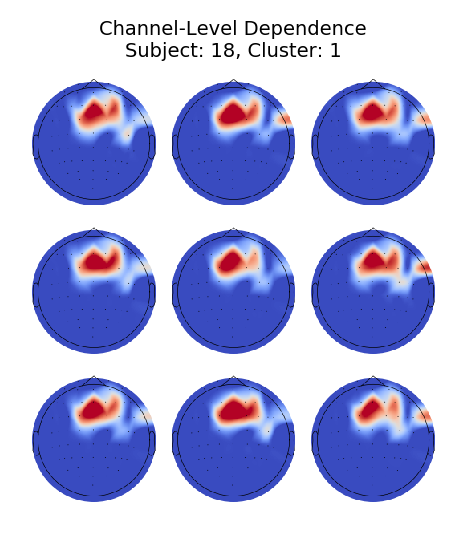

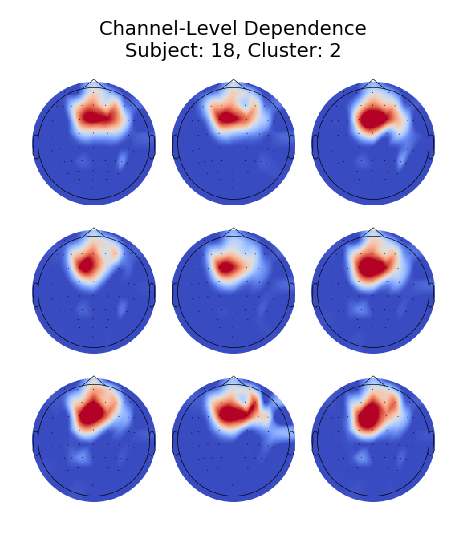

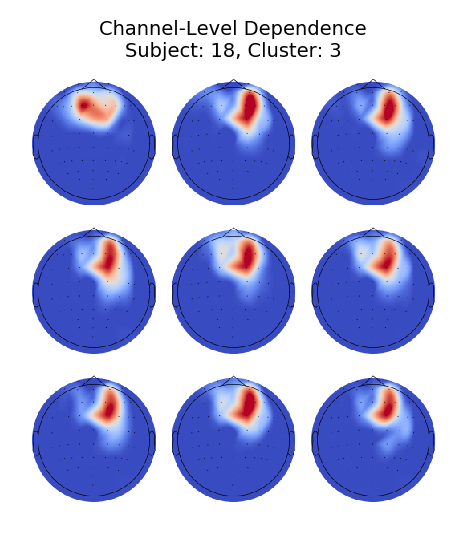

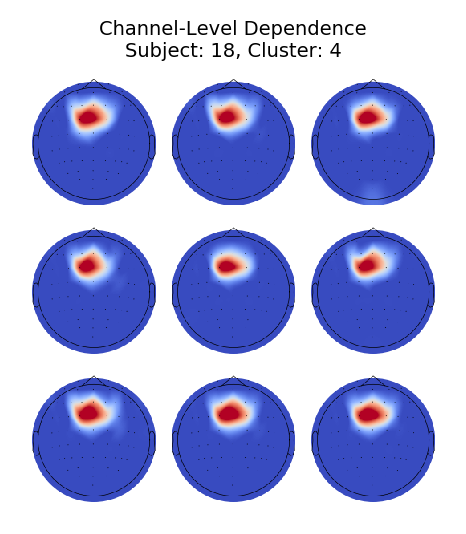

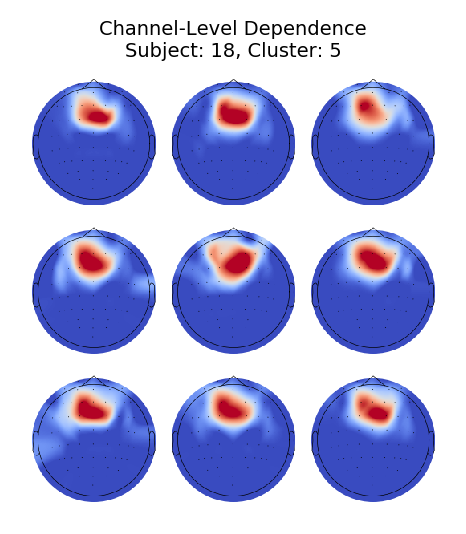

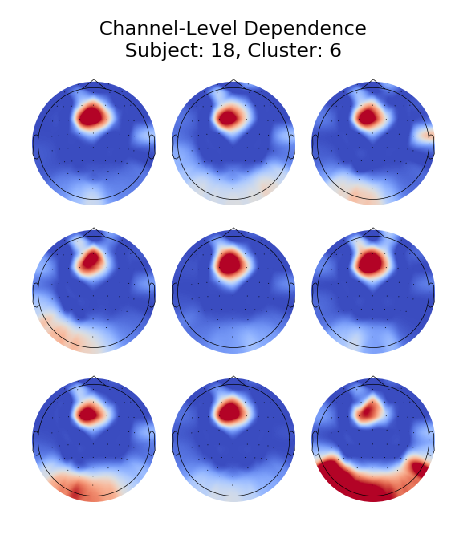

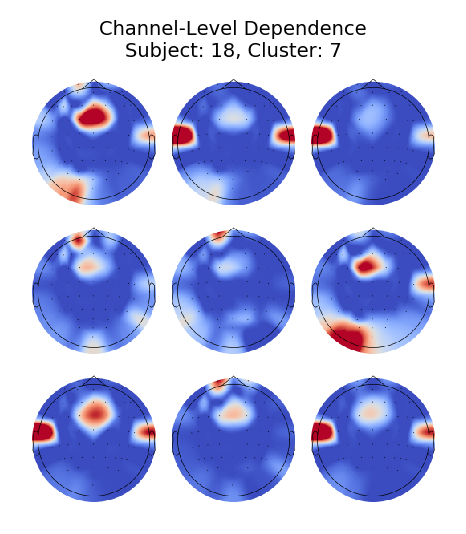

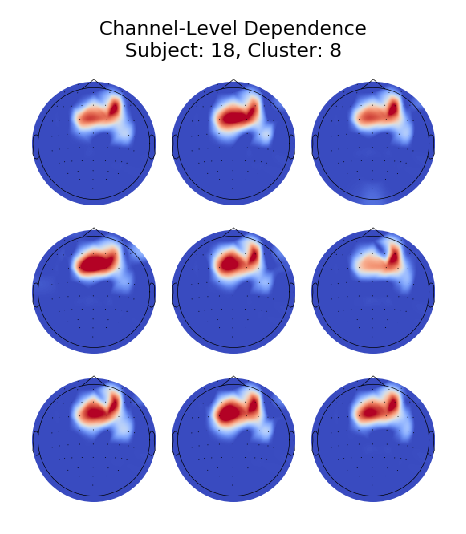

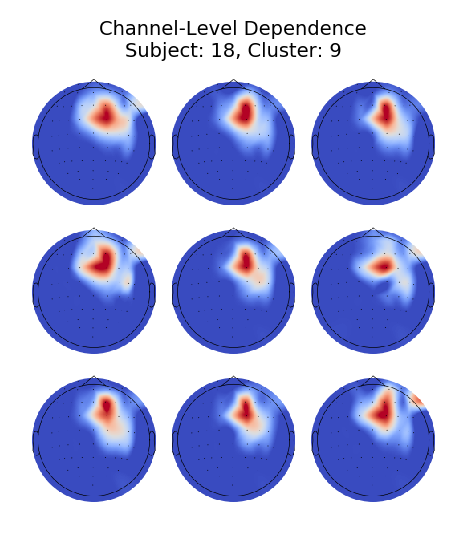

In [46]:
import torchvision

from matplotlib.image import imread

import mne
import torch

channel_names = ['Fp1', 'AF7', 'AF3', 'AFz', 'F7', 'F5', 'F3', 'F1', 'Fz', 'FT7', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'P7', 'P5', 'P3', 'P1', 'Pz', 'PO7', 'PO3', 'POz', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']

for index_subject in [18]:
    for index_cluster in range(0, 9):
        to_show_list = torch.load('./save_heatmap/to_show_list_subj_{0}_mov_{1}'.format(index_subject, index_cluster))
        heatmap_ = torch.clip(to_show_list[0][:, 0], 0, 100).mean(2)
        fig_list = []

        for k, heatmap in enumerate(heatmap_[:9]):
            # Convert Torch tensor to Numpy array
            heatmap_np = heatmap.numpy()

            # Create montage and info objects
            montage = mne.channels.make_standard_montage('standard_1005')
            info = mne.create_info(channel_names, sfreq=250, ch_types='eeg')
            info.set_montage(montage)
            evoked = mne.EvokedArray(heatmap_np[:, np.newaxis], info, tmin=0)

            fig, ax = plt.subplots()
            mne.viz.plot_topomap(heatmap_np, info, axes=ax, res=300, contours=0, image_interp='cubic', cmap='coolwarm', show=False)
        #         ax.set_title('Timepoint {0}, Heatmap {1}'.format(t + 1, k + 1), fontsize=8)

            # Save the current figure
            fig.savefig('test.png', dpi=50, bbox_inches='tight', pad_inches=0.1)
            plt.close(fig)  # Close the current figure to avoid displaying it here

            # Load the saved figure and add it to the list
            img = imread('test.png')
            fig_list.append(img)
            
        torchvision.utils.save_image(torch.from_numpy(np.array(fig_list)).permute(0, 3, 1, 2)[:], 'output.png', nrow=3, padding=10, normalize=True, range=None, scale_each=False, pad_value=0)
        img = imread('output.png')
        plt.figure(figsize=(3, 3), dpi=200)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        plt.title('Channel-Level Dependence\nSubject: {0}, Cluster: {1}'.format(index_subject, index_cluster+1), fontsize=7, pad=-2)
        plt.show()

# 5. Extract Channel-Level Dependence

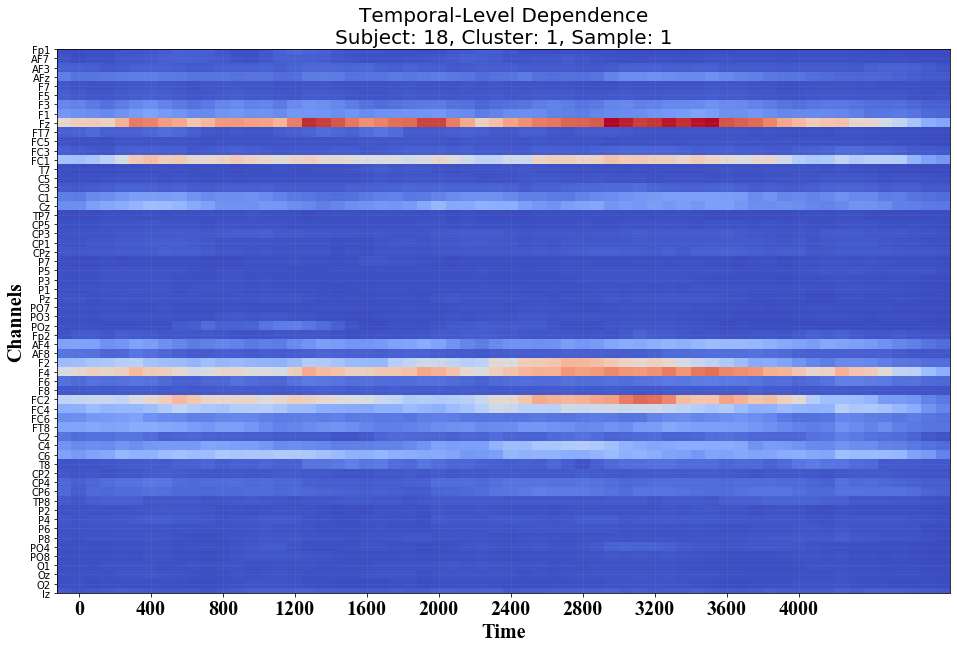

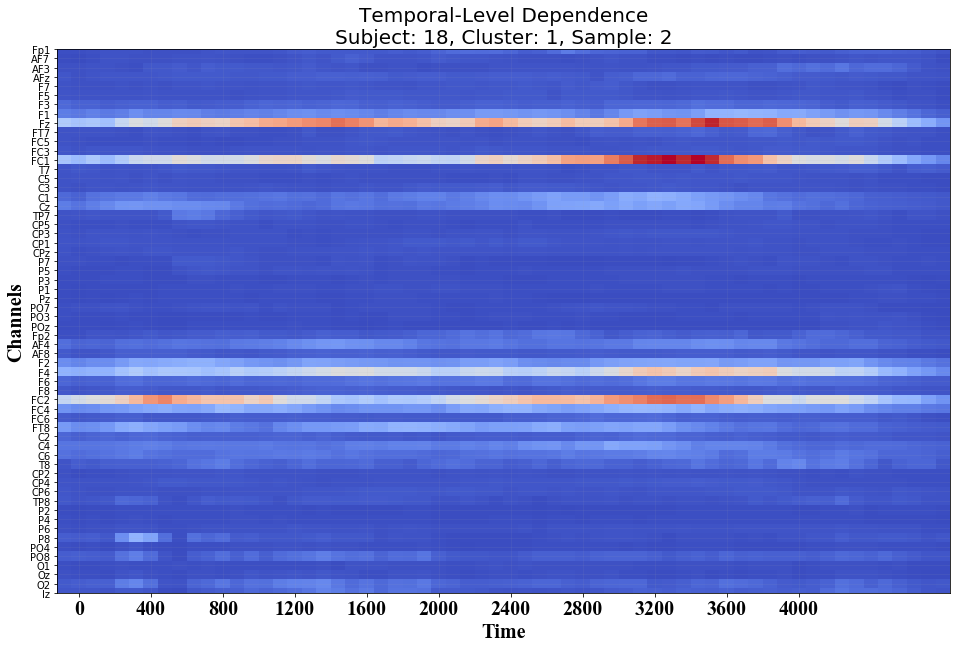

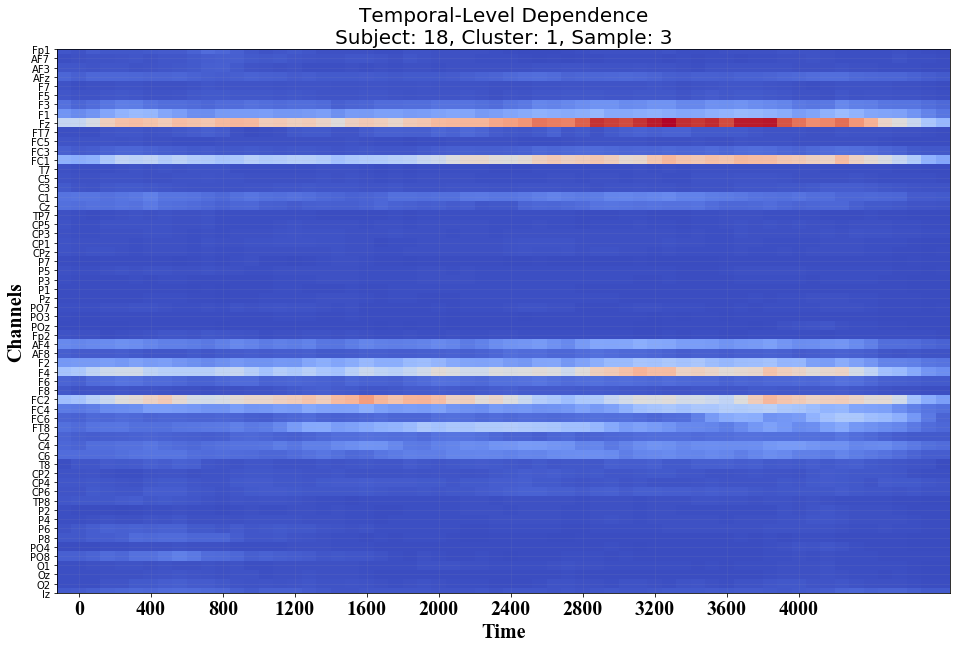

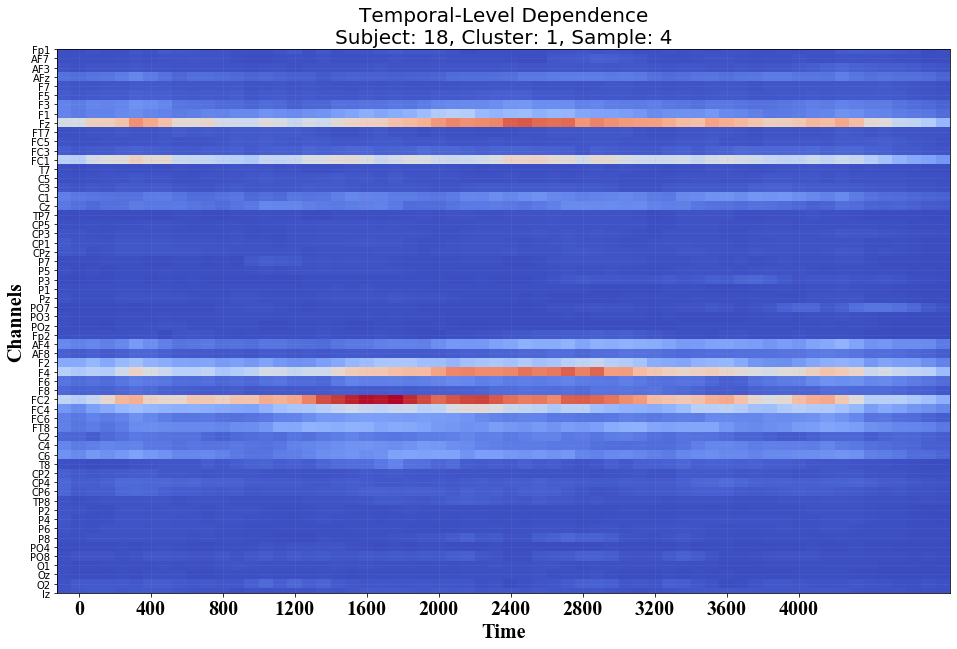

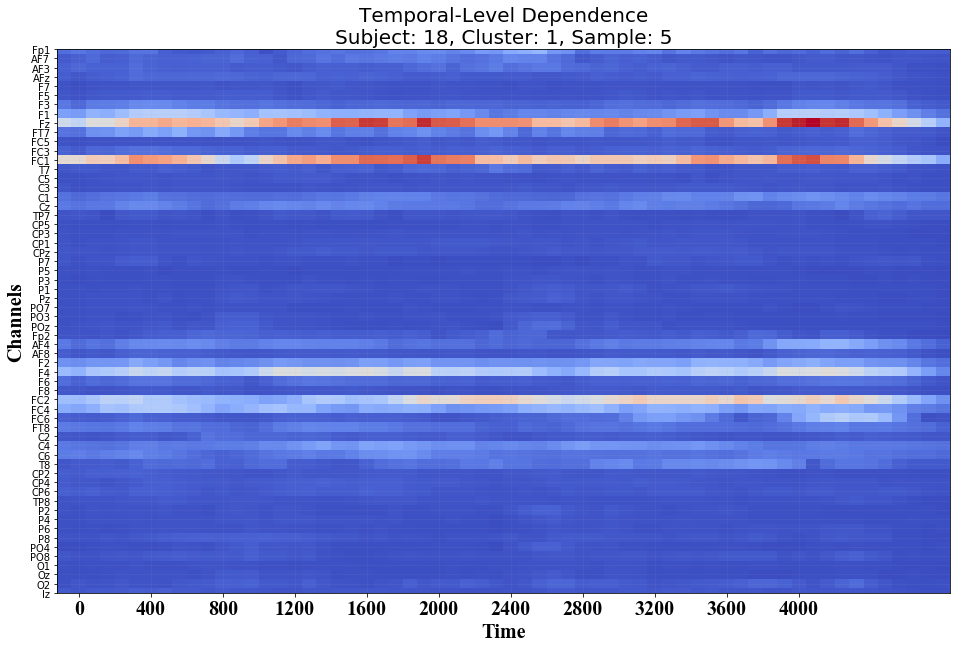

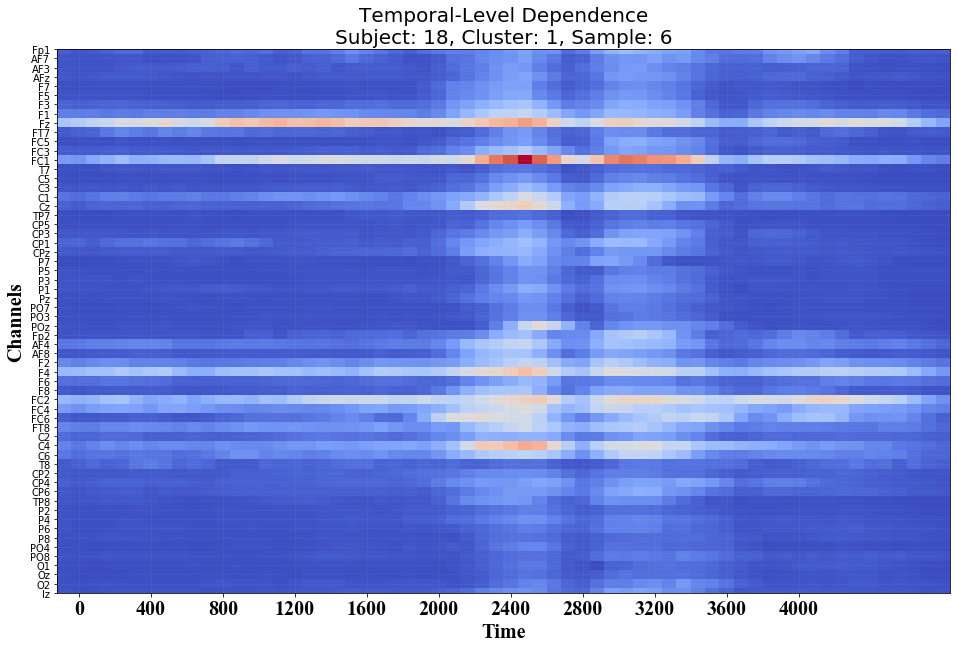

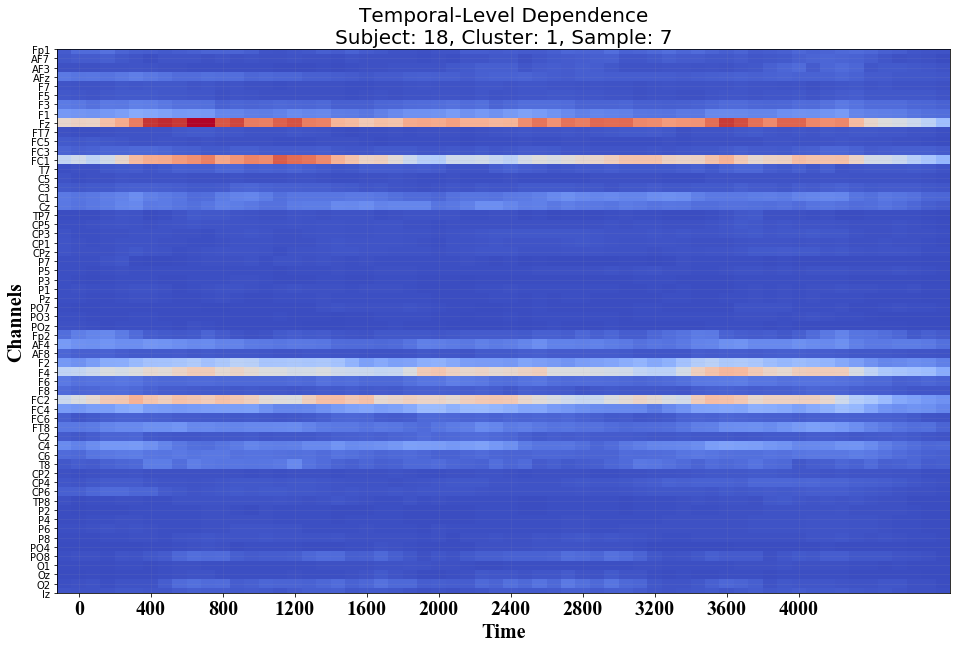

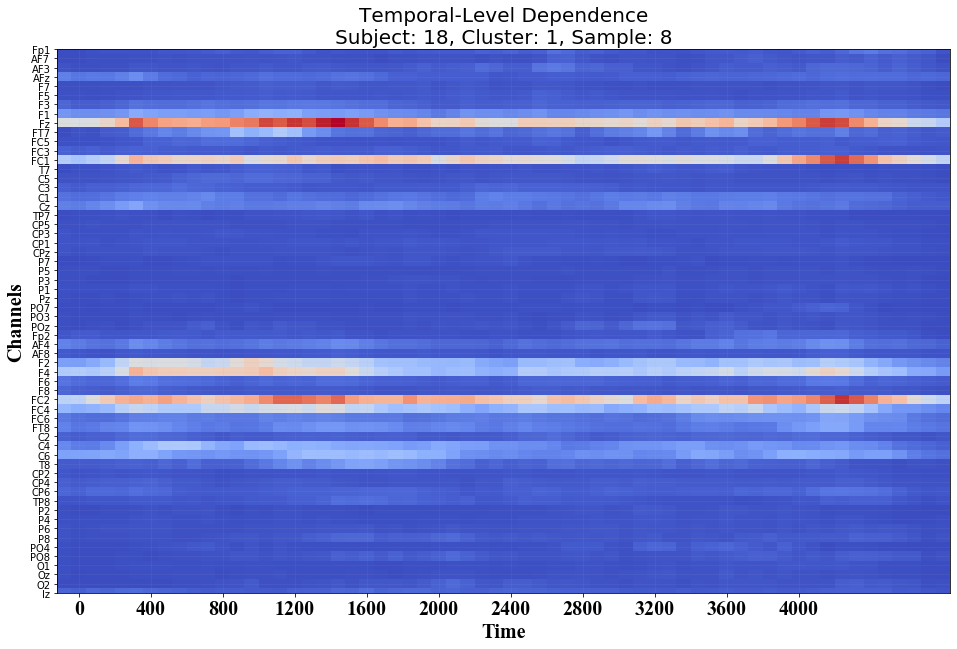

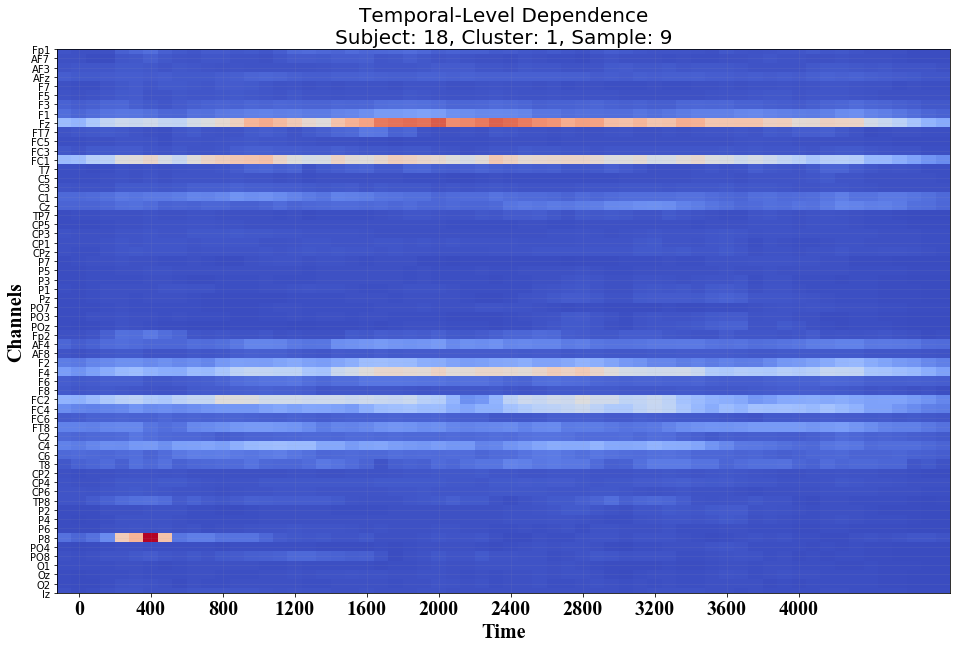

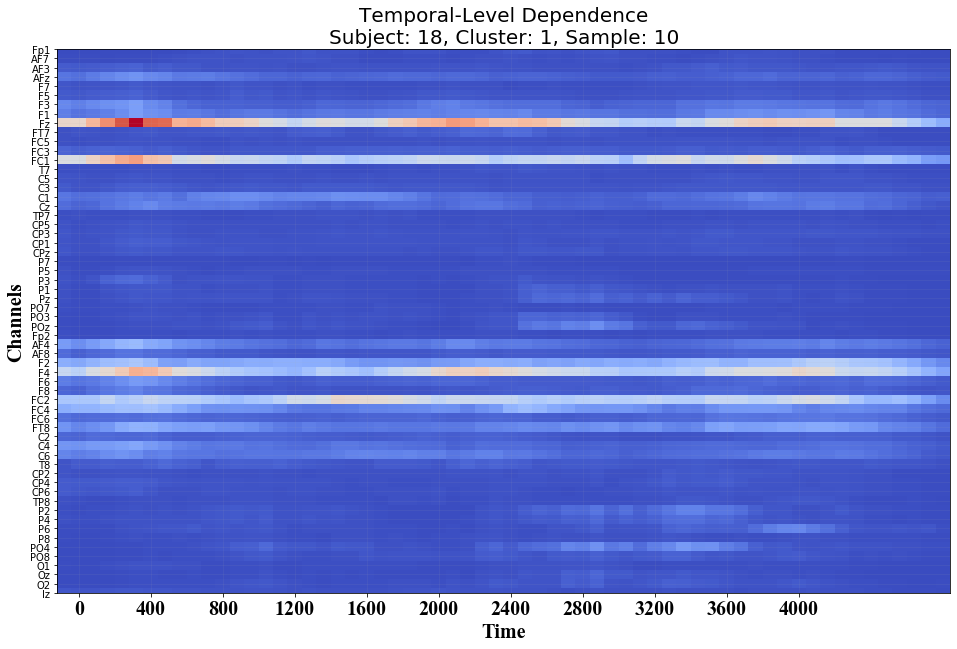

In [65]:
from matplotlib.font_manager import FontProperties

calibri_font = FontProperties()
calibri_font.set_family('Times New Roman')
calibri_font.set_size(20)
calibri_font.set_weight('bold')

index_subject = 18
index_cluster = 0

to_show_list = torch.load('./save_heatmap/to_show_list_subj_{0}_mov_{1}'.format(index_subject, index_cluster))
heatmap_ = torch.clip(to_show_list[0][:, 0], 0, 100).mean(2)

for k in range(0, 10):
    plt.figure(figsize=(16, 10))
    plt.imshow(to_show_list[2][k][0], aspect='auto', cmap='coolwarm', alpha=1, interpolation=None)
    plt.gca().set_yticks(np.arange(to_show_list[2].shape[-2]))
    plt.gca().set_yticklabels(np.array(channel_names)[-240:], fontsize=10)
    plt.xlabel('Time', fontsize=40, fontproperties=calibri_font)
    plt.ylabel('Channels', fontsize=40,fontproperties=calibri_font)

    plt.grid(None, alpha=0.1)
    plt.xticks(np.linspace(1, to_show_list[2][j, 0].shape[1]-11, 11), np.linspace(0, 4000, 11).astype('int'), fontsize=20, fontproperties=calibri_font)  # Adjust step and fontsize as needed
    
    plt.title('Temporal-Level Dependence\nSubject: {0}, Cluster: {1}, Sample: {2}'.format(index_subject, index_cluster+1, k+1), fontsize=20)
    plt.show()